# Image Stitching using SIFT Algorithm and RANSAC

In this notebook, we will implement an image stitching process using the Scale-Invariant Feature Transform (SIFT) algorithm. The stitching process involves the following steps:

#### 1. SIFT Algorithm Implementation

We will begin by implementing the SIFT algorithm from scratch. SIFT is a feature extraction algorithm that detects keypoints and computes descriptors for matching. Our SIFT implementation will be used to extract keypoints from images.

#### 2. Image Keypoints Extraction

We will apply our SIFT algorithm to extract keypoints from two images that we want to stitch together.

#### 3. Nearest Neighbor and Homography

Next, we will train a nearest neighbor algorithm on the SIFT data of one image. The nearest neighbor algorithm helps find corresponding keypoints between the two images. Using these corresponding keypoints, we will compute the homography matrix using the RANSAC (Random Sample Consensus) algorithm. The homography matrix represents the geometric transformation between the images.

#### 4. Image Transformation and Stitching

With the computed homography matrix, we will transform the second image to align with the first image. This process involves removing black boundaries resulting from the transformation. The stitched image is then created by combining the transformed image with the first image.

By the end of this notebook, you will have a practical understanding of how SIFT, nearest neighbor, and RANSAC algorithms can be applied to stitch two images seamlessly.

Let's get started with the implementation!


In [1]:
%load_ext autoreload
%autoreload 2
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.transform import rotate
from python.general_functions import show_images, normalize_img
from python.sift_extractor import SIFT
from skimage.color import rgb2gray
from sklearn.neighbors import NearestNeighbors
import numpy as np
import cv2

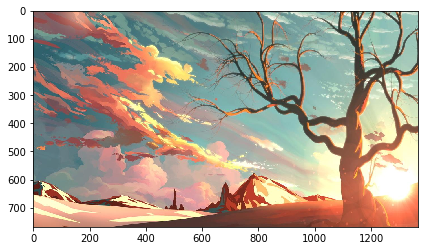

In [2]:
# read img
img = io.imread("images/img.jpg")
io.imshow(img)
plt.show()

Create two images sharing some pixels from the original image

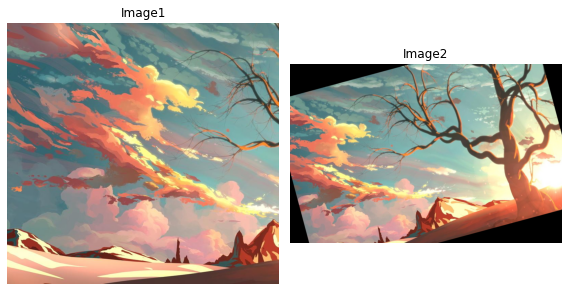

In [3]:
img1 = img[:, :800]
img2 = rotate(img[:, 200:], 15, False)
show_images([img1, img2], ["Image1", "Image2"], figsize=(8, 6), show_axis=False)

In [4]:
# convert both images to gray
img1_gray = rgb2gray(img1)
img2_gray = rgb2gray(img2)

In [5]:
# get sift descriptors for both images
sift_ = SIFT()
sift_summary1 = sift_.extract_sift_data(img1_gray)
sift_summary2 = sift_.extract_sift_data(img2_gray)

In [6]:
# Get nearest neighbor for each feature point
k_neighbors = 1  # Number of neighbors to find (in this case, the nearest neighbor)
model = NearestNeighbors(n_neighbors=k_neighbors)

# Fit the model on feature points of image1
model.fit(sift_summary1["Descriptor"].to_list());


In [7]:
def compute_homography_matrix(src_sift, dst_sift, nearest_neighbors_model, threshold_distance=0.7):
    '''calculates homography matrix of transforming source image to destination image'''
    
    # Find nearest neighbors for each descriptor in the source keypoints
    distances, indices = nearest_neighbors_model.kneighbors(src_sift["Descriptor"].to_list())

    # Filter indices based on the threshold distance
    filtered_indices = indices[distances < threshold_distance].ravel()

    # Extract corresponding points from the source and target keypoints
    source_points = np.array(src_sift.iloc[distances < threshold_distance]['Position'].to_list())[:, :2]
    target_points = np.array(dst_sift.take(filtered_indices)['Position'].to_list())[:, :2]

    # Estimate homography matrix using RANSAC
    # computes the homography matrix (H) to transform points from the source image (srcPoints) to the destination image (dstPoints)
    homography_matrix, _ = cv2.findHomography(source_points.astype(np.float32), target_points.astype(np.float32), 
                                              cv2.RANSAC, ransacReprojThreshold=5)

    return homography_matrix

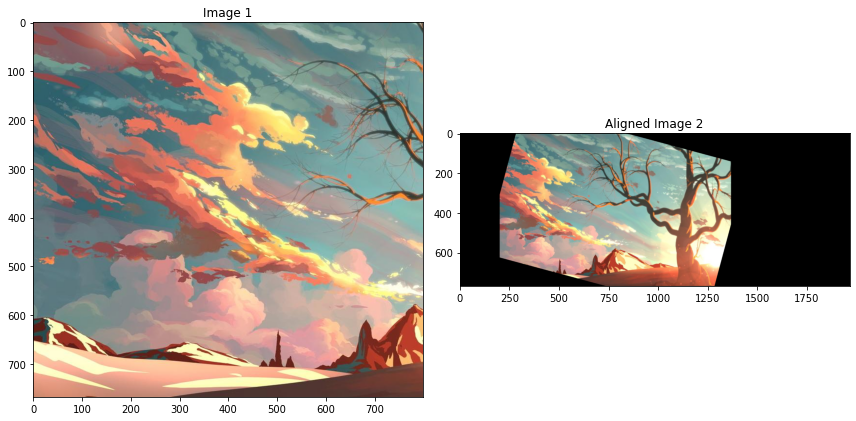

In [8]:
# Compute homography matrix for transforming image2 to image1 coordinates
a_m = compute_homography_matrix(sift_summary2, sift_summary1, model, 1)

# Apply the affine transformation to the image
height1, width1 = img1.shape[:2]
height2, width2 = img2.shape[:2]

output_size = (width1 + width2, height1)
img2_transformed = cv2.warpPerspective(img2, a_m, output_size, borderMode=cv2.BORDER_TRANSPARENT)


# Visualize the result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img2_transformed)
plt.title('Aligned Image 2')

plt.tight_layout()
plt.show()

In [9]:
def stitch_two_images(img1, img2, x_offset=0, img1_left=False):
    """
    Stitch two images horizontally.

    Parameters:
    - img1: First input image to be stitched.
    - img2: Second input image to be stitched.
    - x_offset: Horizontal offset to adjust the stitching position of img1.
    - img1_left: Boolean indicating whether img1 is on the left (True) or right (False).

    Returns:
    - result_image: The stitched image.
    """
    # Normalize input images
    img1 = normalize_img(img1)
    img2 = normalize_img(img2)

    # Get dimensions of img1
    h1, w1 = img1.shape[:2]

    # Create an identity transformation matrix with horizontal offset
    m = np.eye(3)
    m[0, 2] = x_offset

    # Warp img1 using the transformation matrix
    img1_warped = cv2.warpPerspective(img1, m, (w1 + x_offset, h1))

    # Initialize the stitched image with zeros
    stitched_img = np.zeros(img2.shape)

    # Place the warped img1 on the left or right side of the stitched image
    if img1_left:
        stitched_img[:, :w1 + x_offset] = img1_warped
    else:
        stitched_img[:, :w1] = img1_warped

    # Create masks for pixels with values in both images
    mask_both = np.all((stitched_img != 0, img2 != 0), axis=0)

    # Create a new image by taking the mean of pixels with values in both images
    mean_image_both = np.zeros_like(img2, dtype=np.float32)
    mean_image_both[mask_both] = (stitched_img[mask_both] + img2[mask_both]) / 2

    # Create a new image by adding other pixels together
    result_image = stitched_img + img2

    # Combine the two images by replacing pixels with mean values
    result_image[mask_both] = mean_image_both[mask_both]

    return result_image

In [10]:
def find_bounding_box(img):
    """
    Find the bounding box of the main object in a binary or grayscale image.

    Parameters:
    - img: Input image (binary or grayscale).

    Returns:
    - x: X-coordinate of the top-left corner of the bounding box.
    - y: Y-coordinate of the top-left corner of the bounding box.
    - w: Width of the bounding box.
    - h: Height of the bounding box.
    """

    # Convert the image to grayscale if it's in RGB format
    if len(img.shape) > 2:
        gray = rgb2gray(img)
    else:
        gray = img.copy()

    # Convert the grayscale image to a binary mask
    binary_mask = cv2.threshold(gray * 255, 1, 255, cv2.THRESH_BINARY)[1]
    binary_mask = binary_mask.astype(np.uint8)

    # Make a copy of the binary mask
    binary_mask = binary_mask.copy()

    # Define a kernel for morphological closing to fill small holes
    closing_kernel = np.ones((15, 15), np.uint8)

    # Apply closing to the binary mask
    result_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, closing_kernel)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(result_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (main object)
    max_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box coordinates
    x, y, w, h = cv2.boundingRect(max_contour)

    # Get the initial mask at bounding box coordinates
    mask = result_mask[y:y+h, x:x+w]

    # Iterate to refine the bounding box by adjusting its position
    while np.any(mask == 0):
        # Save the previous state of the mask
        prev_mask = mask.copy()

        # Adjust the bounding box
        x += 2
        y += 2
        w -= 4  # Decrease width by 4 to adjust for both sides
        h -= 4  # Decrease height by 4 to adjust for both top and bottom
        mask = result_mask[y:y+h, x:x+w]

        # Check if the adjustment changed the mask
        if np.array_equal(mask, prev_mask):
            break

    return x, y, w, h

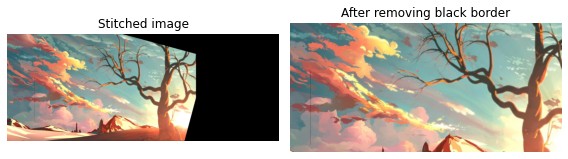

In [11]:
stitched_img = stitch_two_images(img1, img2_transformed, img1_left=False)
x, y, w, h = find_bounding_box(stitched_img)
show_images([stitched_img, stitched_img[y:y+h, x:x+w]], 
            ["Stitched image", "After removing black border"],
            figsize=(8, 8), show_axis=False)

# Conclusion

In this notebook, we implemented image stitching using the SIFT algorithm. The process involved keypoint extraction, nearest neighbor training, homography computation with RANSAC, and seamless image transformation. This hands-on experience showcases the power of feature extraction and geometric transformation in computer vision.
